In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import re

Appointments to the Supreme Court have been some of the most divisive and heated moments of the Trump presidency, starting even before he came to office.  The first appointment he made was to the seat vacated by Antonin Scalia in 2016, which Senate Republicans under Mitch McConnell refused to consider filling with President Obama's nominee, Merrick Garland (see https://www.republicanleader.senate.gov/newsroom/remarks/mcconnell-on-supreme-court-nomination for a statement from McConnell on the issue).  When Anthony Kennedy announced his retirement in 2018, the president nominated Brett Kavanaugh, and he was later confirmed along strict party lines amidst allegations of sexual assault.  The president's last nominee, Amy Coney Barrett, was confirmed less than a month before the election which he lost, leading to accusations that the appointment was undemocratic and, in light of Senate Republicans' behavior in 2016 with Garland, hypocrticial.  It was all the more stinging for liberals that the seat had been vacated by Justice Ginsburg, whose replacement will almost certainly mean a significant change in the Court's ideological makeup and future jurisprudence.  While the eventual effects of Mr. Trump's appointees are still unclear, it seems likely that we will experience another rightward shift in the Court's opinions.  Since the Unites States operates under the Common Law, these opinions carry the weight of law (known as _case law_, to distinguish it from _statutory law_ which is passed by Congress) and are considered _binding precedent_, which is to say that future courts will be required to abide by the decisions.  So the Supreme Court could be about to make conservative precedents that will be very hard to reverse, even by possible future liberal courts.

We know the Supreme Court has issued important decisions in the past which have greatly altered the legal landscape in the United States (noteworthy examples include Gideon v. Wainwright (https://supreme.justia.com/cases/federal/us/372/335/), mandating court-appointed lawyers where the defendent cannot afford counsel; Miranda v. Arizona (https://supreme.justia.com/cases/federal/us/384/436/), which established an obligation for police to inform detainees of their consitutional rights; and Roe v. Wade (https://supreme.justia.com/cases/federal/us/410/113/), which created a nation-wide right to abortion).  There have been swings in the ideological makeup of the Supreme Court in the past.  In particular, the Warren Court is notable for its many liberal rulings, with some even calling the period a "Consititutional revolution" (see https://scholarlycommons.law.wlu.edu/cgi/viewcontent.cgi?article=1814&context=wlulr and https://web.archive.org/web/20191003223936/https://core.ac.uk/download/pdf/73968804.pdf).  Following appointments of Ronald Reagan, the court shifted considerably to the right (see https://constitutioncenter.org/blog/ronald-reagans-big-impact-on-the-supreme-court/), with Reagan elevating the conservative William Rehnquist to the office of Chief Justice and appoiting three new associates: O'Connor, Scalia, and Kennedy.  The Rehnquist court is known for its conservative tendencies, and while it did not reverse the most profound decisions of the Warren Court, it did not generally expand on them (see https://www.theatlantic.com/magazine/archive/2005/04/rehnquist-the-great/303820/ for more information on Rehnquist, especially his tactical skill in using the powers of the Chief Justice to achieve his desired legal outcome).

I was curious about the long-term effects of these courts and their influence on American law; in particular, how significant are the cases from the "Constitutional revolution" of the Warren court, and do we observe new important cases during and after the Reagan era (during the Rehnquist Court)?  To answer this, we need some standard of what makes a court case "important" in a legal sense, and how we can measure this in an objective way.  In countries that operate under the Common Law, when courts make a ruling on a case, they will often write an _opinion_ which gives the reasons for their decision.  Because of the importance of precedent under the Common Law, judges will frequently choose to cite previous cases which are similar, or which are relevant to making a decision in the case at hand.  This gives us a fairly obvious metric for determining important cases: those which are frequently cited are more influential.  This is reminiscent of another famous problem: that of page ranking.  If we imagine cases as webpages and citations as links, this problem can be recast as a problem where we want to rank pages according to thier influence.  Google famously had an algorithm for this, and many libraries on graphs implement it, so this will likely be a very convenient and useful metric for gauging the impact of a decision.

In [2]:
# Volume 326 corresponds to the cases decided early in the Vinson court in 1945,
# as the Second World War came to a close.  Volume 571 is the last volume compiled
# by the U.S. reports and includes cases as recent as 2014.
VOLUME_START = 326
VOLUME_END = 571
# For searching a page for court citations
case_regex = re.compile('\d+\s+U\.\s*S\.\s+\d+')
# For extracting the volume and case number from an appropriately formatted citation
case_volume_regex = re.compile('(\d+)\s+U\.S\.\s+(\d+)')
wiki_url_base = 'https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_'
cases = []
# For removing certain issues related to html formatting.  In particular, tags can
# interfere with citations if part of the citation is bold or italicized, and spaces
# rendered in html with nbsp; will not be marked as whitespace by regular expressions
# so we remove these obstacles.
html_fixer = re.compile('(<[^>]*>)')
space_fixer = re.compile('(nbsp;)|(&#32;)')
i = VOLUME_START
while i <= VOLUME_END:
    r = requests.get(wiki_url_base + str(i))
    s = r.text
    s = html_fixer.sub('', s)
    s = space_fixer.sub(' ', s)
    # finds all case citations on the webpage
    matches = case_regex.findall(s)
    for j in range(len(matches)):
        # fixing some formatting issues to avoid inconsistency
        # We want the format '\d{3} U\.S\. \d{1-3}'
        matches[j] = matches[j].replace('U. S.', 'U.S.')
    cases = cases + matches
    i += 1
# removing duplicate cases sometimes found due to the same citation occuring
# in a hyperlink.  We also sort the cases alphabetically, which does not sort
# by page exactly, but at least divides the volumes into discrete blocks in
# increasing order
cases = list(set(cases))
cases.sort()
print(len(cases))

10107


In [3]:
# A list which contains, at entry i, a list of all the cases cited by cases[i].
# It will be the basis of the edge list we create our graph with
cases_cited = []
current_volume = str(VOLUME_START)
justia_url_base = 'https://supreme.justia.com/cases/federal/us/'\
# A map from cases to the years the cases were decided.
cases_years = {}
failed_cases = []
# for finding the year of a case from its heading on justia's website
year_regex = re.compile('\d+\s+U.\s*S.\s+\d+\s+\((\d{4})\)')
for c in cases:
    m = case_volume_regex.match(c)
    # gathering the case and volume numbers to prepare a search
    volume,  case = m[1], m[2]
    if volume != current_volume and int(volume) % 20 == 0:
        # This loop can take a very long time.  This print
        # statement shows when 20 volumes have been completed.
        print('starting volume ', volume)
        current_volume = volume
    case_url = justia_url_base + volume + '/' + case
    r = requests.get(case_url)
    
    # This extracts the year from the heading for the case and stores
    # it for later use.
    year_matches = year_regex.findall(r.text)
    if year_matches:
        cases_years[c] = int(year_matches[0])
    else:
        # some cases mentioned in the wikipedia lists cannot be found
        # on justia, and I struggle to find mention of them elsewhere
        # Since they number only about 150, I have omitted these cases
        failed_cases.append(c)
        continue
    
    # find all cases mentioned on the webpage for this particular case
    matches = case_regex.findall(r.text)
    for i in range(len(matches)):
        # Fixing formatting again.  We want the same format as we had
        # when we .gathered cases earlier for these citations (which
        # are themselves cases)
        matches[i] = matches[i].replace('U. S.', 'U.S.')
    # we will not allow multiedges for our purposes.  Case A either
    # references Case B at least once or it does not mention it at all
    cases_cited.append(list(set(matches)))
    
# Removing the cases for which no year could be found
cases = [c for c in cases if c not in failed_cases]
print('Number of failed cases: ', len(failed_cases))
print('number of cases examined: ', len(cases), 'number of citation lists: ', len(cases_cited))


starting volume  340
starting volume  360
starting volume  380
starting volume  400
starting volume  420
starting volume  440
starting volume  460
starting volume  480
starting volume  500
starting volume  520
starting volume  540
starting volume  560
Number of failed cases:  156
number of cases examined:  9951 number of citation lists:  9951


In [4]:
# This case is given as being decided in 1053.  If true, this would be some
# of the oldest legal precedent in Anglo-Saxon law, but it's more likely a
# typo or a machine's misreading of a 9 as a 0.
cases_years['346 U.S. 119'] = 1953

In [5]:
# remove references to cases not in our list of cases, which
# will include cases from before the start of our time period
# of interest, and citations to the inner pages of cases already
# cited in the decision
pruned_cases_cited = []
for l in cases_cited:
    pruned_list = [case for case in l if case in cases]
    pruned_cases_cited.append(pruned_list)
# by the way the references were collected, cases will reference
# themselves, so we should correct that.
for i in range(len(cases)):
    if cases[i] in pruned_cases_cited[i]:
        pruned_cases_cited[i].remove(cases[i])
cases_cited = pruned_cases_cited

In [6]:
# This will tell us how many citations we were able to collect.
num_citations = 0
for l in pruned_cases_cited:
    num_citations += len(l)
print(num_citations)

91373


In [7]:
import networkx as nx

Cases' references to each other are one-way, in that a prior case is used to judge a current one, and not the other way around, so we want a directed graph.  This fact also means that the structure of this graph will for the most part avoid cycles, but there may be occasions where the Court decided two cases contemporaneously and one refers to a later-indexed case within the same volume (and possible vice-versa); but no case will ever cite a case which occurs in a later volume.

In [8]:
G = nx.DiGraph()
for case in cases:
    G.add_node(case)
for i in range(len(cases)):
    case1 = cases[i]
    adjacencies = pruned_cases_cited[i]
    for case2 in adjacencies:
        G.add_edge(case1, case2)

In [9]:
ranks = nx.pagerank(G, max_iter = 200)

In [10]:
years_list = list(cases_years.values())
ranks_list = list(ranks.values())
df = pd.DataFrame({'case' : cases, 'year' : years_list, 'rank' : ranks_list})

now = 2014 # last year the reporter has covered is 2014, so this the natural "current year"

# because cases can reference past cases, but not future ones, it is reasonable to
# expect that the earliest cases will be the most influential simply because they have
# had more chances to accumulate citations.  It seems appropriate to attempt to adjust
# the rank somehow, either by number of years since, or by number of cases that occured
# after.  We will examine both.
df['rank per year'] = df.apply(lambda tup: tup['rank'] / (now - tup['year'] + 1), axis=1)
df['rank per cases after'] = df.apply(lambda tup: tup['rank'] / (len(df[df['year'] >= tup['year']])), axis=1)

In [11]:
df.sort_values(by='rank per year', ascending=False).head(10)

,case,year,rank,rank per year,rank per cases after
34,326 U.S. 501,1946,0.009551,0.000138,9.627164e-07
35,326 U.S. 517,1946,0.008835,0.000128,8.905014e-07
42,326 U.S. 60,1945,0.008688,0.000124,8.730523e-07
48,326 U.S. 77,1945,0.006940,0.000099,6.974141e-07
43,326 U.S. 607,1946,0.005733,0.000083,5.779103e-07
59,327 U.S. 186,1946,0.005560,0.000081,5.604159e-07
660,340 U.S. 474,1951,0.004840,0.000076,5.203061e-07
661,340 U.S. 498,1951,0.004442,0.000069,4.774977e-07
2,326 U.S. 135,1945,0.004432,0.000063,4.453447e-07
33,326 U.S. 496,1946,0.004359,0.000063,4.394213e-07


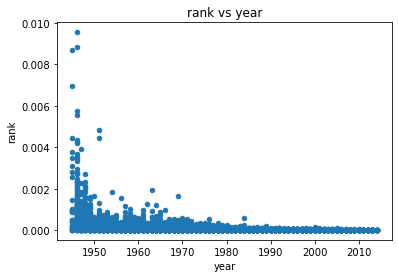

In [12]:
df.plot.scatter(x='year', y='rank', title='rank vs year')

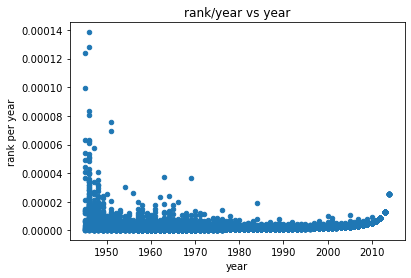

In [13]:
df.plot.scatter(x='year', y='rank per year', title='rank/year vs year')

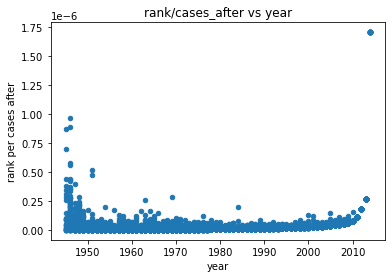

In [14]:
df.plot.scatter(x='year', y='rank per cases after', title='rank/cases_after vs year')

In [15]:
# the first 15 values are all 2014 cases at with high ratios of rank to cases
# after, since they have very few cases after
df.sort_values(by='rank per year', ascending=False).head(20)

,case,year,rank,rank per year,rank per cases after
34,326 U.S. 501,1946,0.009551,0.000138,9.627164e-07
35,326 U.S. 517,1946,0.008835,0.000128,8.905014e-07
42,326 U.S. 60,1945,0.008688,0.000124,8.730523e-07
48,326 U.S. 77,1945,0.006940,0.000099,6.974141e-07
43,326 U.S. 607,1946,0.005733,0.000083,5.779103e-07
59,327 U.S. 186,1946,0.005560,0.000081,5.604159e-07
660,340 U.S. 474,1951,0.004840,0.000076,5.203061e-07
661,340 U.S. 498,1951,0.004442,0.000069,4.774977e-07
2,326 U.S. 135,1945,0.004432,0.000063,4.453447e-07
33,326 U.S. 496,1946,0.004359,0.000063,4.394213e-07


Interestingly, by all metrics, the earliest cases uder the Vinson court are found to be among the most influential, except where we divide by number of cases after which leads us to believe that the most recent cases are extremely influential for the number of cases coming fater them, which makes some sense because almost no cases come after them; but even then, the Vinson Court's decisions are the next-most influential cases.  This suggests that the court's opinions from that time have been most influential, more so even than the Warren Court's.  This seems out of place with what we would expect from our anecdotal evidence that the Warren court presided over a revolution in our view of the constitution, and that Ronald Reagan's appointees molded the court's ideology into an influentially conservative one.  Let us see what happens to our assessment when the Vinson Court's cases are removed from our consideration.

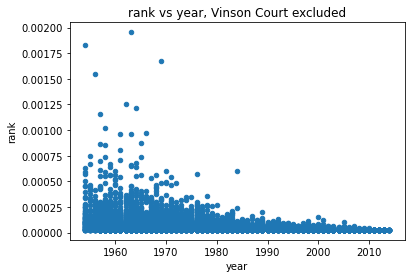

In [16]:
vinson_court_end = 1953
old_cases = df[df['year'] <= vinson_court_end]['case']
new_df = df[df['year'] > vinson_court_end].copy()
for case in old_cases:
    if case in G:
        G.remove_node(case)

ranks = nx.pagerank(G, max_iter=200)
new_df['ranks'] = list(ranks.values())
new_df['rank per year'] = new_df.apply(lambda tup: tup['rank'] / (now - tup['year'] + 1), axis=1)
new_df['rank per cases after'] = \
new_df.apply(lambda tup: tup['rank'] / (len(new_df[new_df['year'] >= tup['year']])), axis=1)

new_df.plot.scatter(x='year', y='rank', title='rank vs year, Vinson Court excluded')

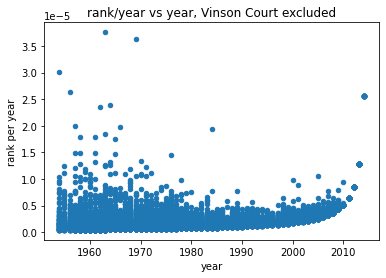

In [17]:
new_df.plot.scatter(x='year', y='rank per year', title='rank/year vs year, Vinson Court excluded')

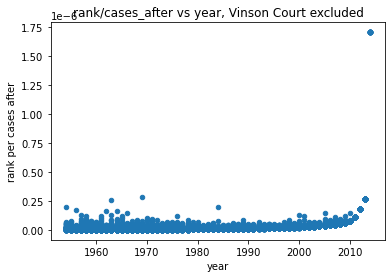

In [18]:
new_df.plot.scatter(x='year', y='rank per cases after', title = 'rank/cases_after vs year, Vinson Court excluded')

In [19]:
# we again exclude the most recent cases, whose values for this metric is distorted by the
# small number of years they have existed.
new_df.sort_values(by='rank per year', ascending=False).head(35)[new_df['year'] < 2010]

<ipython-input-19-88e9fa2c083f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df.sort_values(by='rank per year', ascending=False).head(35)[new_df['year'] < 2010]


,case,year,rank,rank per year,rank per cases after,ranks
2494,372 U.S. 335,1963,0.001954,0.000038,2.606790e-07,0.003259
210,330 U.S. 485,1969,0.001672,0.000036,2.853838e-07,0.000313
996,347 U.S. 483,1954,0.001834,0.000030,2.039811e-07,0.005694
1158,351 U.S. 12,1956,0.001552,0.000026,1.755550e-07,0.003695
2894,377 U.S. 533,1964,0.001215,0.000024,1.689792e-07,0.001951
2273,369 U.S. 186,1962,0.001252,0.000024,1.624293e-07,0.002428
1303,354 U.S. 476,1957,0.001159,0.000020,1.325662e-07,0.003250
3393,384 U.S. 436,1966,0.000971,0.000020,1.451613e-07,0.001534
7006,467 U.S. 837,1984,0.000602,0.000019,1.962496e-07,0.000856
2495,372 U.S. 353,1963,0.000958,0.000018,1.278177e-07,0.001498


This set of cases is more in line with what we expect to see.  372 U.S. 335 is the case Gideon v. Wainwright, which is one of the most prominent decisions by the Warren Court, and 347 U.S. 483 is Brown v. Board of Ed., another landmark which ended the notorious "Separate but Equal" doctrine with regard to racial segregation. 384 U.S. 436 (Miranda v. Arizona) has already been mentioned; and 369 U.S. 186 (Baker v. Carr) and 377 U.S. 533 (Reynolds v. Sims) deal with voting rights; specifically, that legislative districts must be roughly equal in population to preserve the equality of every citizen's vote, and tht this can be enforced by litigation.  One standout among these cases is 467 U.S. 837 (Chevron v. Natural Resources Defense Council), which is from 1984, far later than the mainly Warren-era cases.  It deals with the extent to which executive agencies have felxibility and agency in interpreting laws passed by Congress, and ruled in favor of significant agency.  Notably, we again see no trend for important cases during the Reagan era, which could mean one of many things.  One possibility is that the conventional wisdom that Reagan's compositions significantly altered the federal judiciary is overstated, and his impact is in line with other presidents.  Another is that we have yet to see the full impact of the cases decided by Reagan's appointees, and that as time goes on and more cases cite the Rehnquist Court's cases and cases citing Rehnquist's cases, we will see the Rehnquist Court's cases grow in importance like the Vinson and Burger Courts'; and yet another possibility is that age will tend to make some cases from every Court important and Reagan's cases haven't aged enough yet.  Perhaps some combination of all three is true, in degrees.

That brings us back to the present day.  We have evidence that past decisions can be very influential in the interpretation of current law, and we now have a majority on the Supreme Court which is likely to steer future opinions in a conservative direction.  In some ways, we can rely on the large body of past decisions for stability.  The fact that they are still binding means that barring an extremely radical move by the new Court, we are likely not to see outright reversals of the rulings like Gideon and Miranda which have granted (rightly or wrongly) significant protections to individuals against government.  To reverse these decisions would be to pull out the rug from under a huge body of case law, a move most jurists liberal and conservative shy away from.  In other ways, we have reason to be concerned.  Cases are brewing against tech giants, with claims of monopoly and misinformation being leveled at different companies.  Bound by little precedent, the court may have significant liberty to rule on how technology companies can be regulated, and future courts will be bound by the precedent set by those decisions.  Thus, the consequences of the Court's decisions could be massive.

To reduce the seemingly undemocratic nature of the court, where the timing of one person's death can result in significant changes to how American law in interpreted, some Democrats have proposed expanding the court to fill more seats with liberal justices and restore (or perhaps more than restore) the old status quo.  With Democratic control over the Senate looking unlikely, these plans will probably be shelved for now, but other proposals, like an amendment limiting the tenure of justices, or reduction of the jurisdiction of the Supreme Court, might find their way to fruition if a party with control over the elected branches should ever find itself in conflict with the Court.